# Langkah 2: Model Clustering (K-Means)

**Tujuan:** Menerapkan K-Means clustering pada `user_features.csv` untuk mengelompokkan pengguna ke dalam 'gaya belajar' yang berbeda.

**Alur:**
1.  **Pemuatan & Penskalaan Data:** Memuat `user_features.csv` dan WAJIB melakukan *scaling*.
2.  **Elbow Method:** Menemukan jumlah cluster (K) yang optimal.
3.  **Pelatihan Model Final:** Melatih model K-Means dengan K optimal.
4.  **Penyimpanan:** Menyimpan model (`.joblib`) dan hasil cluster (`.csv`) untuk Langkah 3 & 4.

## 1. Setup & Pemuatan Data

Kita muat *library* yang diperlukan untuk ML (Scikit-learn) dan data `user_features.csv` yang kita buat di Langkah 1.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Mengatur style visualisasi
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
DATA_DIR = '../data/'
MODEL_DIR = '../backend/' # Kita akan simpan model di folder backend

# Pastikan folder backend ada
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

try:
    # Muat tabel fitur kita. Set user_id sebagai index.
    features_df = pd.read_csv(os.path.join(DATA_DIR, 'user_features.csv'), index_col='user_id')
    print(f"Feature table loaded successfully. Shape: {features_df.shape}")
    print(features_df.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Pastikan Anda sudah menjalankan notebook '01_Feature_Engineering.ipynb' terlebih dahulu.")

Feature table loaded successfully. Shape: (2692, 15)
         total_explicit_interactions  total_implicit_interactions  \
user_id                                                             
30                                15                          221   
72                                 8                           22   
114                               82                          168   
277                              197                          481   
343                               15                          296   

         avg_watch_pct  completion_rate  drop_off_rate  avg_duration_watched  \
user_id                                                                        
30           21.333333         6.666667      66.666667            204.000000   
72           99.125000       100.000000       0.000000            209.250000   
114          98.426829        98.780488       1.219512            184.780488   
277          88.065990        82.741117       5.583756         

## 2.1 Penskalaan Data (Data Scaling)

Ini adalah langkah **wajib** untuk K-Means.

Model K-Means bekerja berdasarkan *jarak*. Fitur `total_explicit_interactions` (nilai 5 s/d 880) akan mendominasi fitur `completion_rate` (nilai 0 s/d 100). Ini akan merusak model kita.

**Solusi:** Kita gunakan `StandardScaler` untuk mengubah semua fitur agar memiliki *mean* 0 dan *standard deviation* 1. 

In [3]:
# 1. Inisialisasi Scaler
scaler = StandardScaler()

# 2. Fit & Transform data fitur kita
features_scaled = scaler.fit_transform(features_df)

print("Data scaled successfully.")
print(f"Shape data setelah di-scale: {features_scaled.shape}")

Data scaled successfully.
Shape data setelah di-scale: (2692, 15)


## 2.2 Menemukan K Optimal (Elbow Method)

Kita tidak tahu berapa banyak 'gaya belajar' yang ada. Apakah 3? 5? 8?

Kita akan menggunakan **Elbow Method**: Kita coba jalankan K-Means dengan K=1, K=2, ... K=10, dan kita plot *cost function*-nya (disebut WCSS atau `inertia_`). Kita mencari titik 'siku' (elbow) di mana penambahan cluster baru tidak lagi memberikan penurunan *cost* yang signifikan. 

Calculating WCSS for K=1 to 10...
Calculation complete.


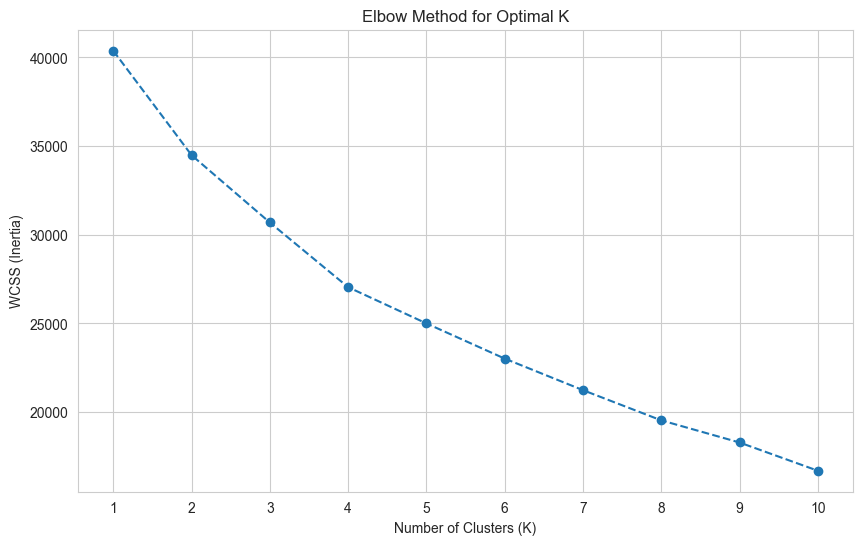

In [4]:
wcss = [] # Within-Cluster Sum of Squares
K_RANGE = range(1, 11) # Mencoba K dari 1 sampai 10

print("Calculating WCSS for K=1 to 10...")
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, 
                    init='k-means++', 
                    max_iter=300, 
                    random_state=42, 
                    n_init=10) # n_init=10 untuk stabilitas
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_) # inertia_ adalah WCSS

print("Calculation complete.")

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_RANGE, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K_RANGE)
plt.grid(True)
plt.show()

## 2.3 Pelatihan Model Final

Setelah melihat *Plot* di atas. Menurut saya 'siku' terlihat jelas pada `K=2` dan `K=4`. 

Ini adalah *trade-off* antara akurasi model (WCSS rendah) dan kemudahan interpretasi (terlalu banyak cluster sulit dijelaskan). Tapi, untuk mencegah hanya pengelompokkan menjadi hanya 2. Saya putuskan memilih `K=4`.

In [ ]:
# --------------- Optimal K -------------------
OPTIMAL_K = 4
# ---------------------------------------------

print(f"Training final model with K={OPTIMAL_K}...")

# Latih model final dengan K optimal
kmeans_final = KMeans(n_clusters=OPTIMAL_K,
                      init='k-means++',
                      max_iter=300,
                      random_state=42,
                      n_init=10)

kmeans_final.fit(features_scaled)

print("Final model trained successfully.")

Training final model with K=4...
Final model trained successfully.


## 2.4 Penyimpanan Model & Hasil Cluster

Kita perlu menyimpan 3 hal:
1.  **`scaler.joblib`**: Scaler SANGAT PENTING. Kita membutuhkannya nanti di API untuk men-skala data baru (user baru) sebelum melakukan prediksi.
2.  **`kmeans_model.joblib`**: Model K-Means yang sudah dilatih.
3.  **`user_features_with_clusters.csv`**: Tabel fitur *original* (tidak di-scale) ditambah satu kolom baru: `cluster`, yang berisi label (0, 1, 2, 3, atau 4) untuk setiap user.

In [7]:
# 1. Simpan Scaler
scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 2. Simpan Model K-Means
model_path = os.path.join(MODEL_DIR, 'kmeans_model.joblib')
joblib.dump(kmeans_final, model_path)
print(f"K-Means model saved to: {model_path}")

# 3. Dapatkan label cluster dan simpan ke file CSV baru
cluster_labels = kmeans_final.labels_

# Tambahkan label sebagai kolom baru ke DataFrame *original* (TIDAK di-scale)
features_df['cluster'] = cluster_labels

# Simpan CSV baru ini. Ini akan kita gunakan di Langkah 3 untuk interpretasi.
output_csv_path = os.path.join(DATA_DIR, 'user_features_with_clusters.csv')
features_df.to_csv(output_csv_path)

print(f"Feature table with cluster labels saved to: {output_csv_path}")
print("\n--- Head of the new DataFrame ---")
print(features_df.head())

Scaler saved to: ../backend/scaler.joblib
K-Means model saved to: ../backend/kmeans_model.joblib
Feature table with cluster labels saved to: ../data/user_features_with_clusters.csv

--- Head of the new DataFrame ---
         total_explicit_interactions  total_implicit_interactions  \
user_id                                                             
30                                15                          221   
72                                 8                           22   
114                               82                          168   
277                              197                          481   
343                               15                          296   

         avg_watch_pct  completion_rate  drop_off_rate  avg_duration_watched  \
user_id                                                                        
30           21.333333         6.666667      66.666667            204.000000   
72           99.125000       100.000000       0.000000      

## Kesimpulan Langkah 2

Pekerjaan kita di sini selesai. Kita sekarang memiliki:
* Model (`kmeans_model.joblib`) dan scaler (`scaler.joblib`) yang siap digunakan oleh API kita di folder `backend/`.
* File `user_features_with_clusters.csv` yang berisi data mentah + label cluster untuk setiap user aktif.

**Langkah selanjutnya (Langkah 3)** adalah bagian yang paling menarik: **Interpretasi Persona**. Kita akan menganalisis file CSV baru itu untuk menjawab: "Apa arti dari `cluster 0`?", "Apa bedanya dengan `cluster 1`?"